## loading stuff
- na primeira vez do 'runtime' tem que instalar odc-ui e rasterstats
- 

In [4]:
!pip install odc-ui rasterstats

In [1]:
import time
start = time.time()


In [3]:
%%time
# the basic
#import rich.table

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# for PC, stac, xarray
import odc.stac
import stackstac
from xrspatial import zonal_stats


import sys
# DEA tools
sys.path.append('/home/jovyan/PlanetaryComputerExamples/CODE/grits/deafrica_tools/')
from plotting import display_map, rgb, map_shapefile

# grits
sys.path.append('/home/jovyan/PlanetaryComputerExamples/CODE/grits/')
from grits import zscore_dataset, humanbytes, get_field, get_lims, get_mms, query_l2a_items, xr_rasterize, calculate_indices


# packages that have to be installed every runtime
import subprocess
import pkg_resources

required = {'rasterstats','odc-ui'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

CPU times: user 186 ms, sys: 12.8 ms, total: 199 ms
Wall time: 198 ms


## Getting the study area

In [4]:
path = '/home/jovyan/PlanetaryComputerExamples/vetorial/FAZENDAS/'

### Fazenda Uniguiri

#### a fazenda toda

got bbox, lat_range, lon_range
   parte                                           geometry
0      1  MULTIPOLYGON (((-54.57278 -16.93966, -54.57686...
1      2  MULTIPOLYGON (((-54.57825 -16.95894, -54.57660...
2      3  MULTIPOLYGON (((-54.59494 -16.96052, -54.59700...
3      4  MULTIPOLYGON (((-54.65092 -16.95305, -54.65196...


<Axes: >

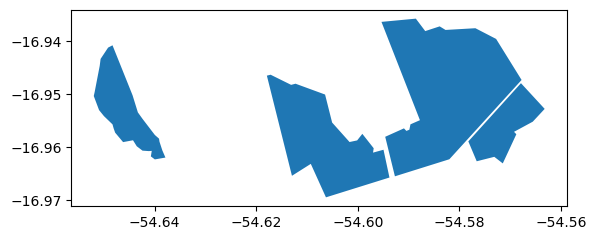

In [5]:
field = gpd.read_file( path + 'fazenda_uniguiri.gpkg')
bbox, lat_range, lon_range = get_lims(field)

print(field.head())
field.plot()

#### piquetes em uma região da fazenda
A fazenda é dividida em 4 regiões (column = 'Re') e dentro há os piquetes ('TID', o "talhão ID"). No .gpkg da fazenda_uniguiri temos o layer 'piquetes_tid' que contém todas as subdivisões da fazenda. 

No exemplo selecinei todos talhões da **Região 80000**

In [7]:
# para um grupo dentro de uma farm
layer = 'piquetes_tid'
column = 'Re'
val = 80000

field = gpd.read_file( path + 'fazenda_uniguiri.gpkg' , layer=layer)
field = field[field[column] == val]

bbox, lat_range, lon_range = get_lims(field)

print(field.head())

# plotting a partir do TID
style={'opacity': 6, 'stroke': 2,'dashArray': '1', 'fillOpacity': 0.5}
map_shapefile(field,'TID',cmap='Set1', **style )

got bbox, lat_range, lon_range
    PID  area_ha    R   ID      SR     Re   Fi     TID  \
0  R8_4      6.4  R8_    4  100000  80000    4  180004   
1     F     10.6    F  NaN  100000  80000  901  180901   
2  R8_5      6.9  R8_    5  100000  80000    5  180005   
3     C      0.7    C  NaN  100000  80000  801  180801   
4  R8_1      6.7  R8_    1  100000  80000    1  180001   

                                            geometry  
0  MULTIPOLYGON (((-54.57526 -16.95986, -54.57705...  
1  MULTIPOLYGON (((-54.57224 -16.96252, -54.57131...  
2  MULTIPOLYGON (((-54.57705 -16.96167, -54.57526...  
3  MULTIPOLYGON (((-54.56787 -16.95268, -54.56744...  
4  MULTIPOLYGON (((-54.57109 -16.95544, -54.57249...  


Label(value='')

Map(center=[-16.955265352726073, -54.57066140325033], controls=(ZoomControl(options=['position', 'zoom_in_text…

### Iacanga - Usina Ipiranga
O shape da Usina Ipiranga em Iacanga (fornecido pelo Vanda). As áreas que fornecem para a usina estão organizadas em, creio que, fazendas com número e nome na coluna 'LAYER', por exemplo: '032 APARECIDA', '001 SAO JORGE'. 

Já os talhões estão numerados unicamente dentro do shape todo a partir da coluna 'AdMapKey'

In [8]:
%%time

field = get_field(path + 'iacanga_22_23.gpkg',
                 column = 'LAYER',
                 ID = '001 SAO JORGE',
                 layer = 'talhoes') #este é o layer do .gpkg

bbox, lat_range, lon_range = get_lims(field)

print(field.head())

style={'opacity': 6, 'stroke': 2,'dashArray': '1', 'fillOpacity': 0.5}
map_shapefile(field,'AdMapKey',cmap='Set1', **style )

got bbox, lat_range, lon_range
      AdMapKey           AREA                                 CENTER  \
85          86  217707.759088  697614.9171,7576942.8279,3001034.0000   
89          90  202947.154458  698056.1989,7576856.8532,3001035.0000   
90          91   31161.560681  697944.6995,7576627.1608,3001036.0000   
2950      2951    2682.476118  700003.6928,7578431.1558,3001005.0000   
4207      4208   99267.364824  697458.6107,7579031.1829,3001012.0000   

      ELEVATION          LAYER                 TID  \
85    3001034.0  001 SAO JORGE    86-001 SAO JORGE   
89    3001035.0  001 SAO JORGE    90-001 SAO JORGE   
90    3001036.0  001 SAO JORGE    91-001 SAO JORGE   
2950  3001005.0  001 SAO JORGE  2951-001 SAO JORGE   
4207  3001012.0  001 SAO JORGE  4208-001 SAO JORGE   

                                               geometry  
85    MULTIPOLYGON Z (((-49.08717 -21.90172 3001034....  
89    MULTIPOLYGON Z (((-49.08253 -21.89938 3001035....  
90    MULTIPOLYGON Z (((-49.08263 -21

Label(value='')

Map(center=[-21.89156825437149, -49.076390601885436], controls=(ZoomControl(options=['position', 'zoom_in_text…

CPU times: user 1.57 s, sys: 40.9 ms, total: 1.61 s
Wall time: 1.66 s


## the Sentinel 2 pathway
1. Fazer a query para o período 'datetime' desejado e setar a cobertura máxima de nuvens. 
2. Montar o datacube (o xarray de dados) no modo **lazy**

In [10]:
datetime = "2022-07-10/2023-10-10"
max_cloud_cover = 30
items = query_l2a_items(bbox, datetime, max_cloud_cover)

 found 130 items


In [11]:
# For Sentinel 2
data = (
    stackstac.stack(
        items,
        assets = ["B11","B12","B08","B06", "B04", "B03","B02", "SCL"], 
        chunksize=256,
        epsg=4326,
        bounds=bbox,
        properties = True,
        fill_value = np.nan,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)

# fix xy names
data = data.rename({'x': 'longitude','y': 'latitude'})
data

<xarray.DataArray 'stackstac-0e82dfc0dafde7b9f7d9d7a49f456349' (time: 130,
                                                                band: 8,
                                                                latitude: 284,
                                                                longitude: 405)>
dask.array<where, shape=(130, 8, 284, 405), dtype=float64, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 2022-07-11...
    id                                       (time) <U54 'S2A_MSIL2A_20220711...
  * band                                     (band) object 'swir16' ... None
  * longitude                                (longitude) float64 -49.1 ... -4...
  * latitude                                 (latitude) float64 -21.88 ... -21.9
    s2:generation_time                       (time) <U27 '2022-07-13T09:32:00...
    ...                                       ...
    gsd                                      (band) float64 20.0 20.0 ... 20.0
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-49.09610957877639, -21.904...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-49.10|\n| 0.00,-0.00,-21.88|\n| 0.00, 0.00,...
    resolution_xy:  (9.726740071158702e-05, 9.089970787456991e-05)

### masking farm and creating zones
São dois passos, mascarar a parte de fora da fazenda e criar o raster com as zonas de análise numeradas em int (**checar se há uma limitação de 100 features**)

In [12]:
#create MASK versao dataarray
masked = True

if masked:
    mask = xr_rasterize(field,data,
                        # x_dim='x',
                        # y_dim='y',
                       #export_tiff='masked2.tiff',
                       ) 

    # #mask data
    data = data.where(mask)

    # #convert to float 32 to conserve memory
    data = data.astype(np.float32)
data

<xarray.DataArray 'stackstac-0e82dfc0dafde7b9f7d9d7a49f456349' (time: 130,
                                                                band: 8,
                                                                latitude: 284,
                                                                longitude: 405)>
dask.array<astype, shape=(130, 8, 284, 405), dtype=float32, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 2022-07-11...
    id                                       (time) <U54 'S2A_MSIL2A_20220711...
  * band                                     (band) object 'swir16' ... None
  * longitude                                (longitude) float64 -49.1 ... -4...
  * latitude                                 (latitude) float64 -21.88 ... -21.9
    s2:generation_time                       (time) <U27 '2022-07-13T09:32:00...
    ...                                       ...
    gsd                                      (band) float64 20.0 20.0 ... 20.0
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-49.09610957877639, -21.904...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-49.10|\n| 0.00,-0.00,-21.88|\n| 0.00, 0.00,...
    resolution_xy:  (9.726740071158702e-05, 9.089970787456991e-05)

### calcular índices
Há várias opções de índices e não tem problema carregar muitas bandas no modo lazy. Optei pelo Leaf Area Index (LAI), Enhanced Vegetation Index (EVI), Normalized Difference Chrolophyl Index (NDCI) e o Bare Soil Index (BSI). Os dois primeiros tento relacionar com biomassa, já o NDCI com a qualidade da biomassa e o BSI com a ausência de biomassa.

In [14]:
# converte o dataarray em dataset
ds_ = data.to_dataset(dim='band') 

# calcula os indices
indices = ["LAI", "EVI","NDCI", "BSI"]
ds = calculate_indices(ds_, 
                       index= indices, 
                       satellite_mission='s2', 
                       drop=True);

humanbytes(ds.nbytes)

Dropping bands ['swir16', 'swir22', 'nir', 'rededge', 'red', 'green', 'blue', None]


'228.34 MB'

### calcular Z-scores
A partir da série temporal, calcular os z-scores baseado em **mean** e **std** mensais.

In [15]:
zscores = zscore_dataset(ds)
humanbytes(zscores.nbytes)

'228.34 MB'

### not so quick diagnostics
Setar os percentis máximos e mínimos para os plots

In [16]:
%%time
# para os IVs
qmin_qmax=[0.02, 0.98]
mms = get_mms(ds, indices, qmin_qmax)

{'LAI': array([0.10676565, 2.48465755]), 'EVI': array([0.06212428, 0.71936365]), 'NDCI': array([0.05451448, 0.50032648]), 'BSI': array([-0.20649089,  0.20762596])}
CPU times: user 56.5 s, sys: 9.21 s, total: 1min 5s
Wall time: 1min 38s


In [17]:
%%time
# para os ZSCORES
qmin_qmax=[0.02, 0.98]
mms = get_mms(zscores, indices, qmin_qmax)

{'LAI': array([-1.45575612,  2.04836359]), 'EVI': array([-1.45575614,  2.04836373]), 'NDCI': array([-1.58274281,  2.06783053]), 'BSI': array([-2.16016367,  1.55233668])}
CPU times: user 60 s, sys: 9.57 s, total: 1min 9s
Wall time: 1min 15s


### plotting zscores
**XXXXXXX PROBLEMAS Quando SLICEIA, dá pau lá pro final, não entendi.**

In [19]:
i1,i2,i3 = 'NDCI','BSI','LAI'

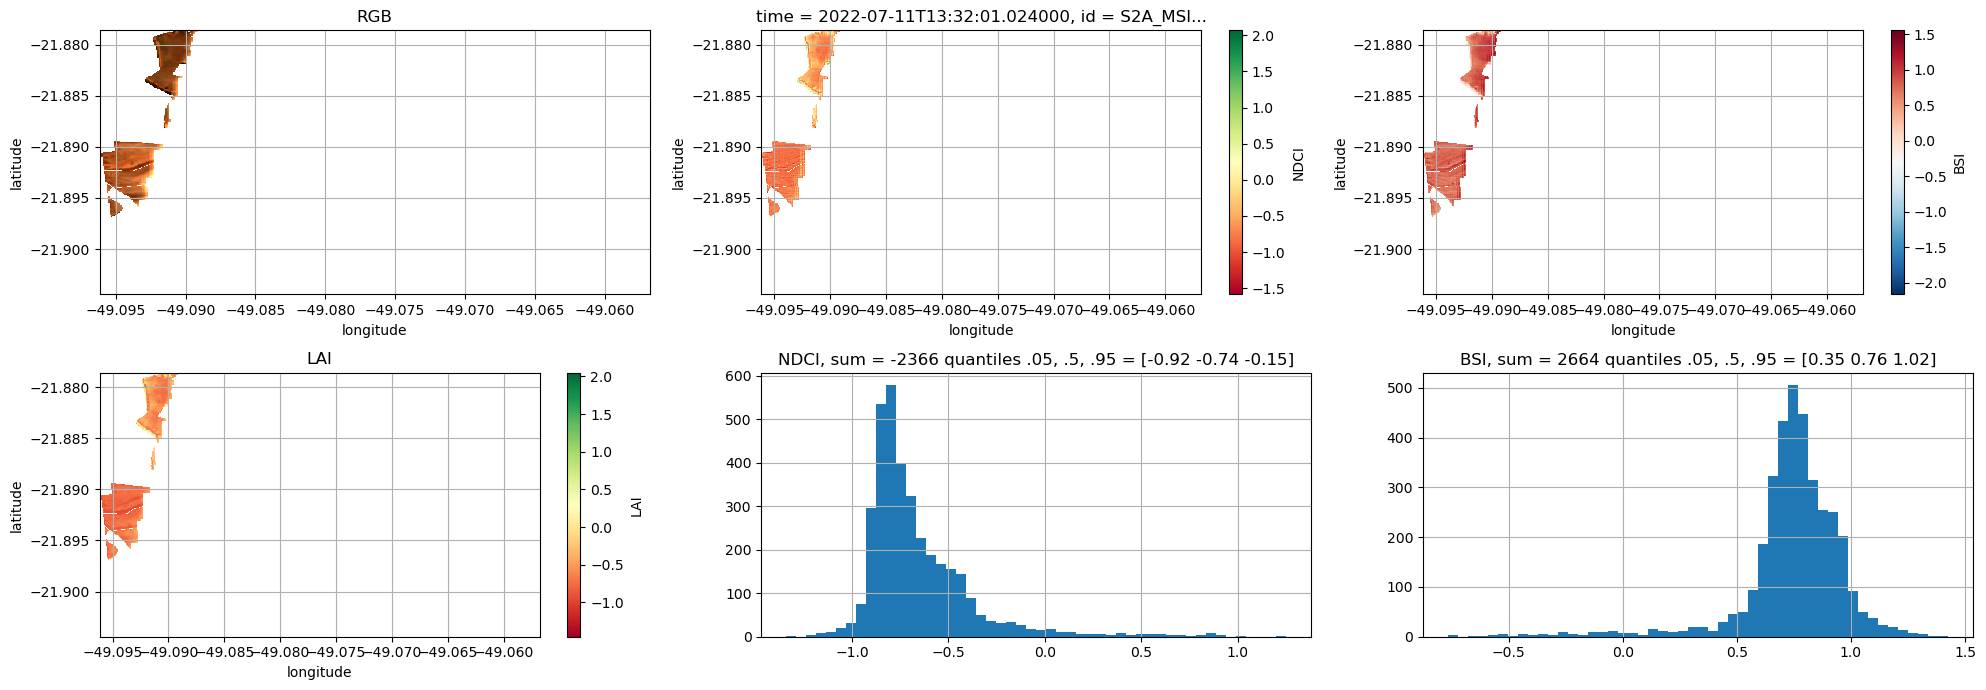

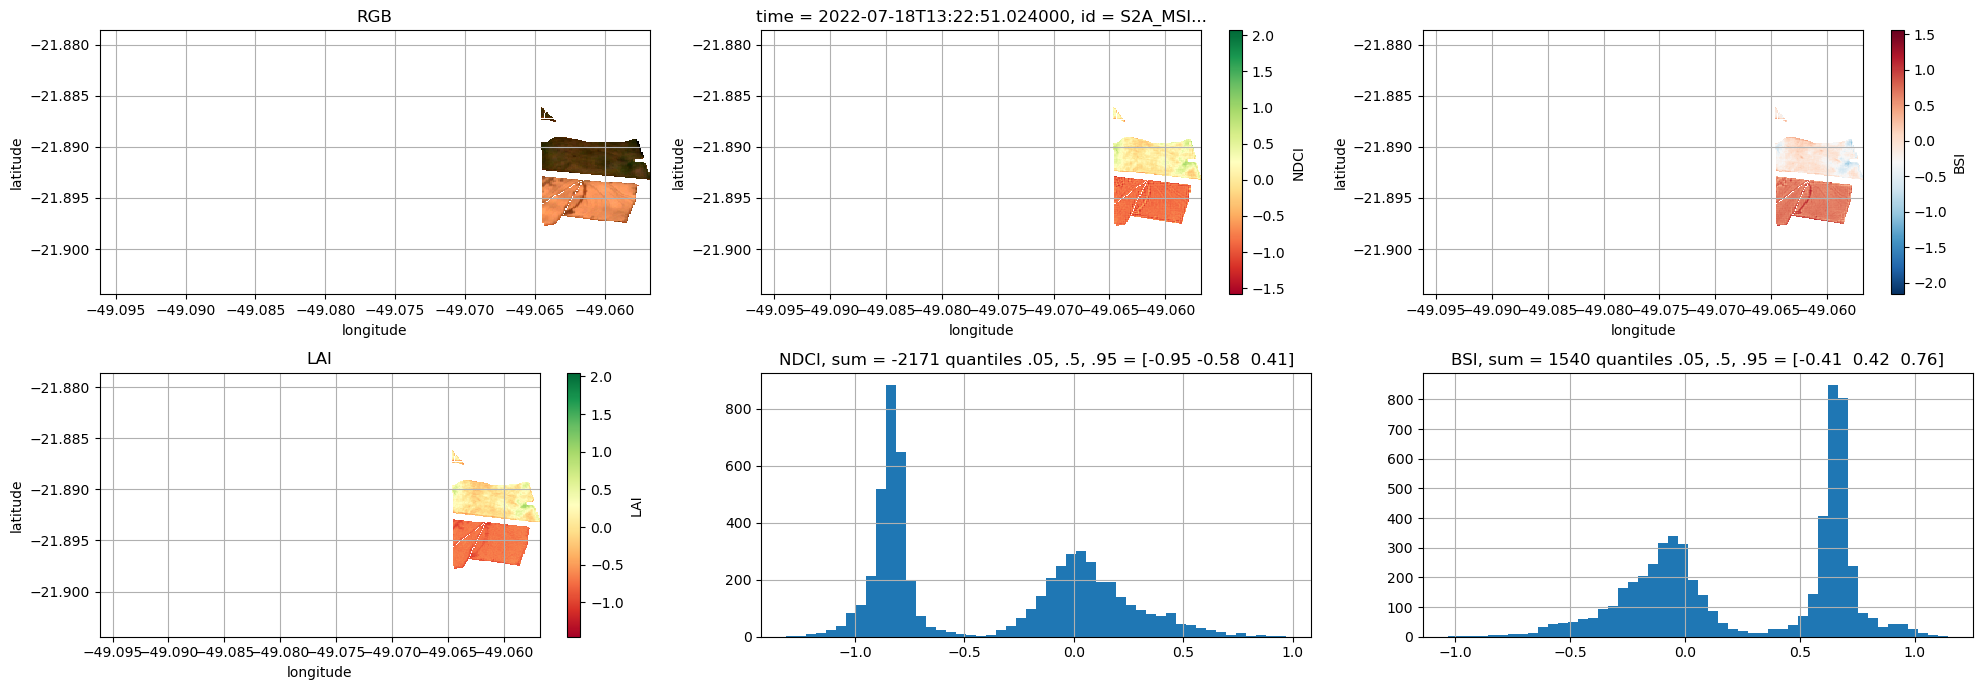

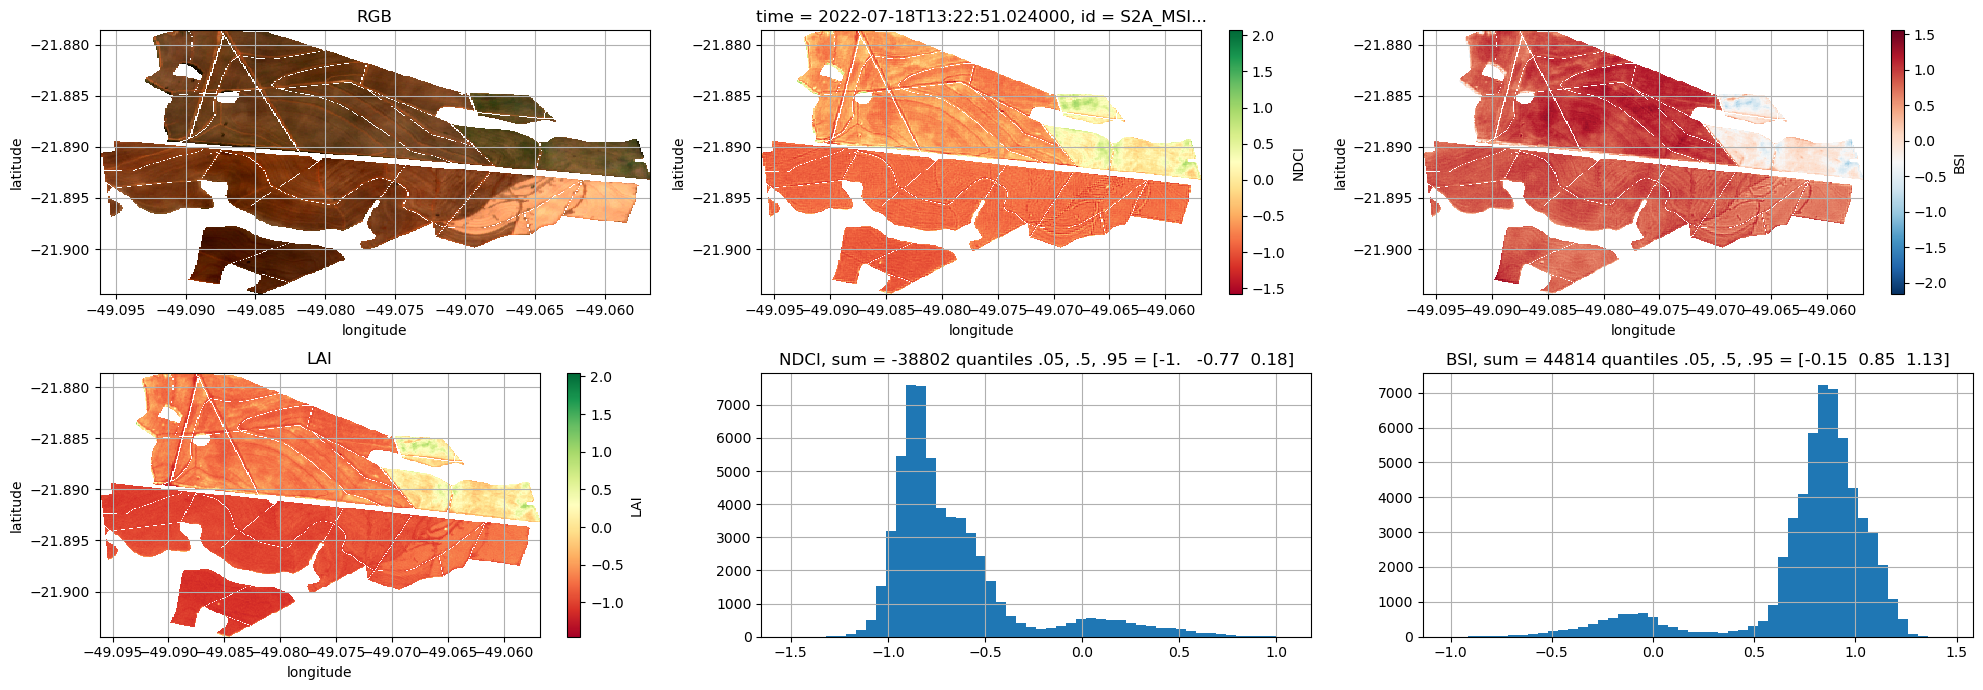

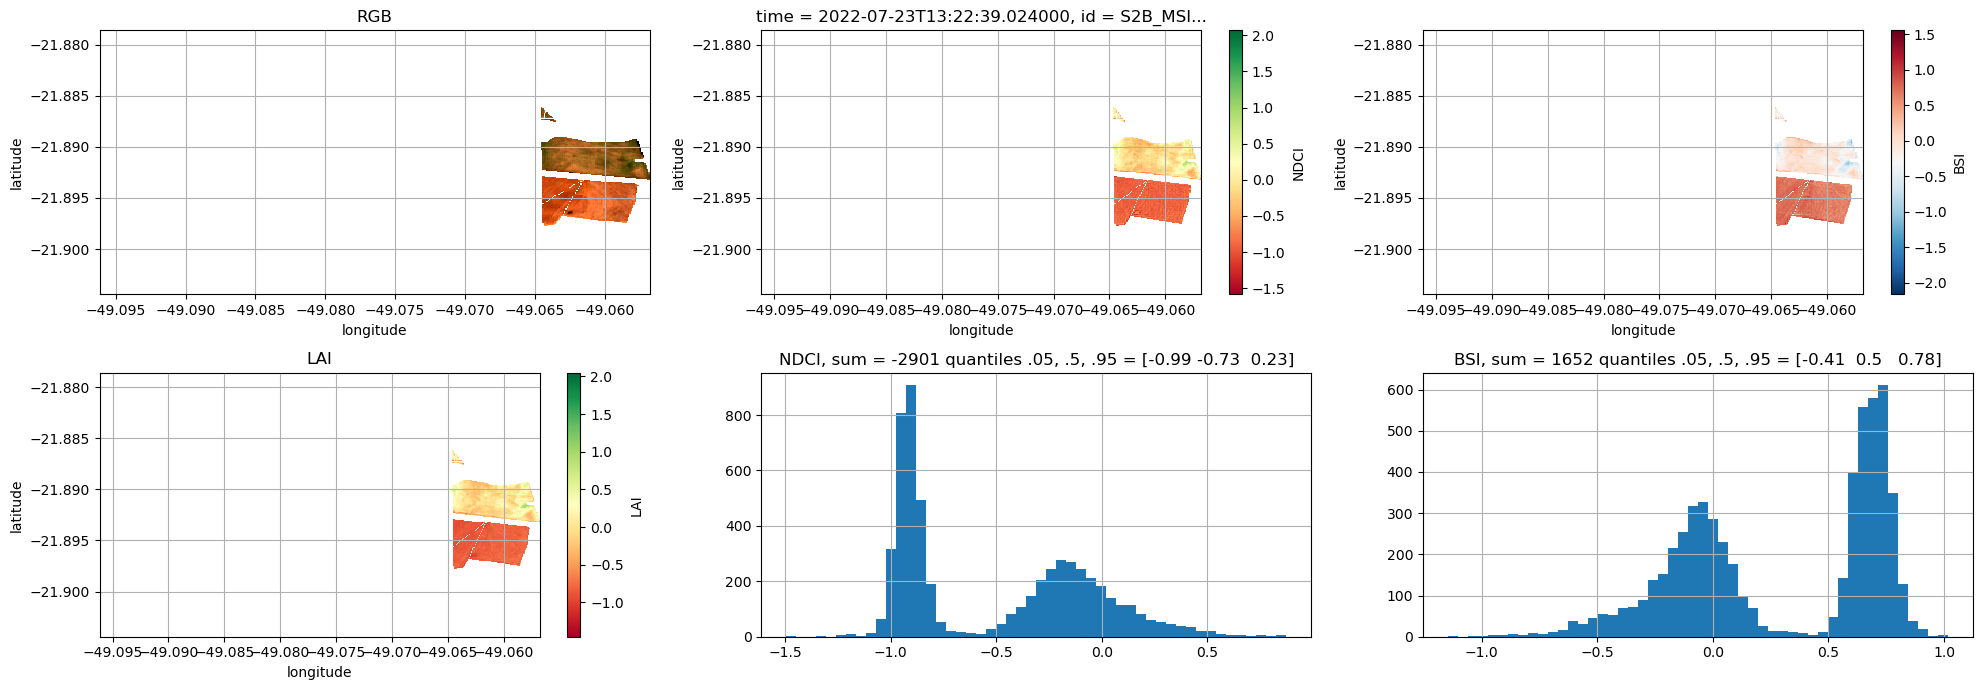

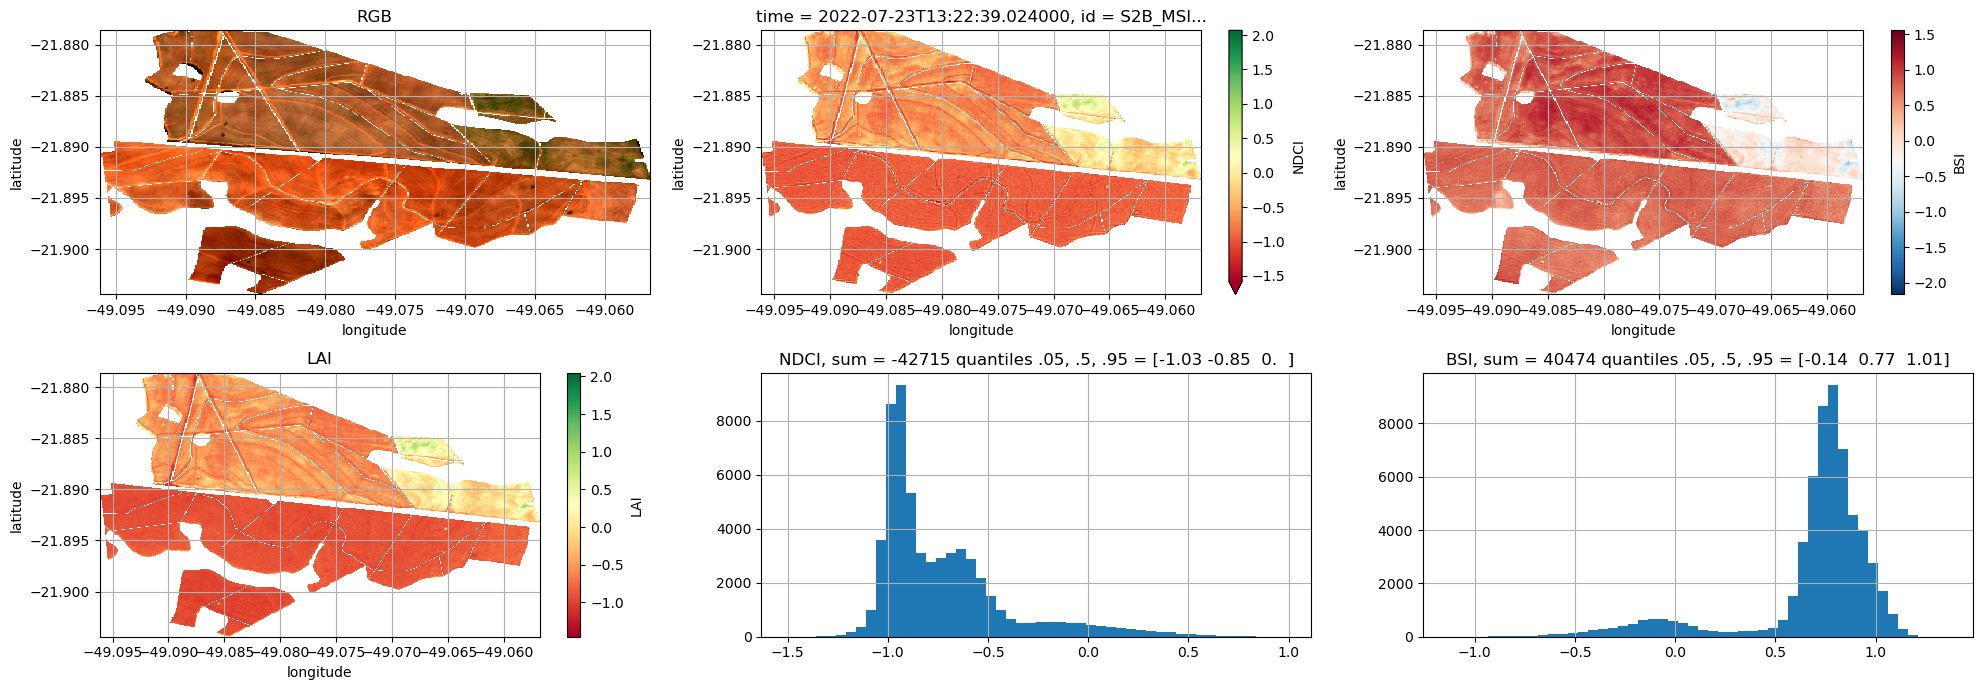

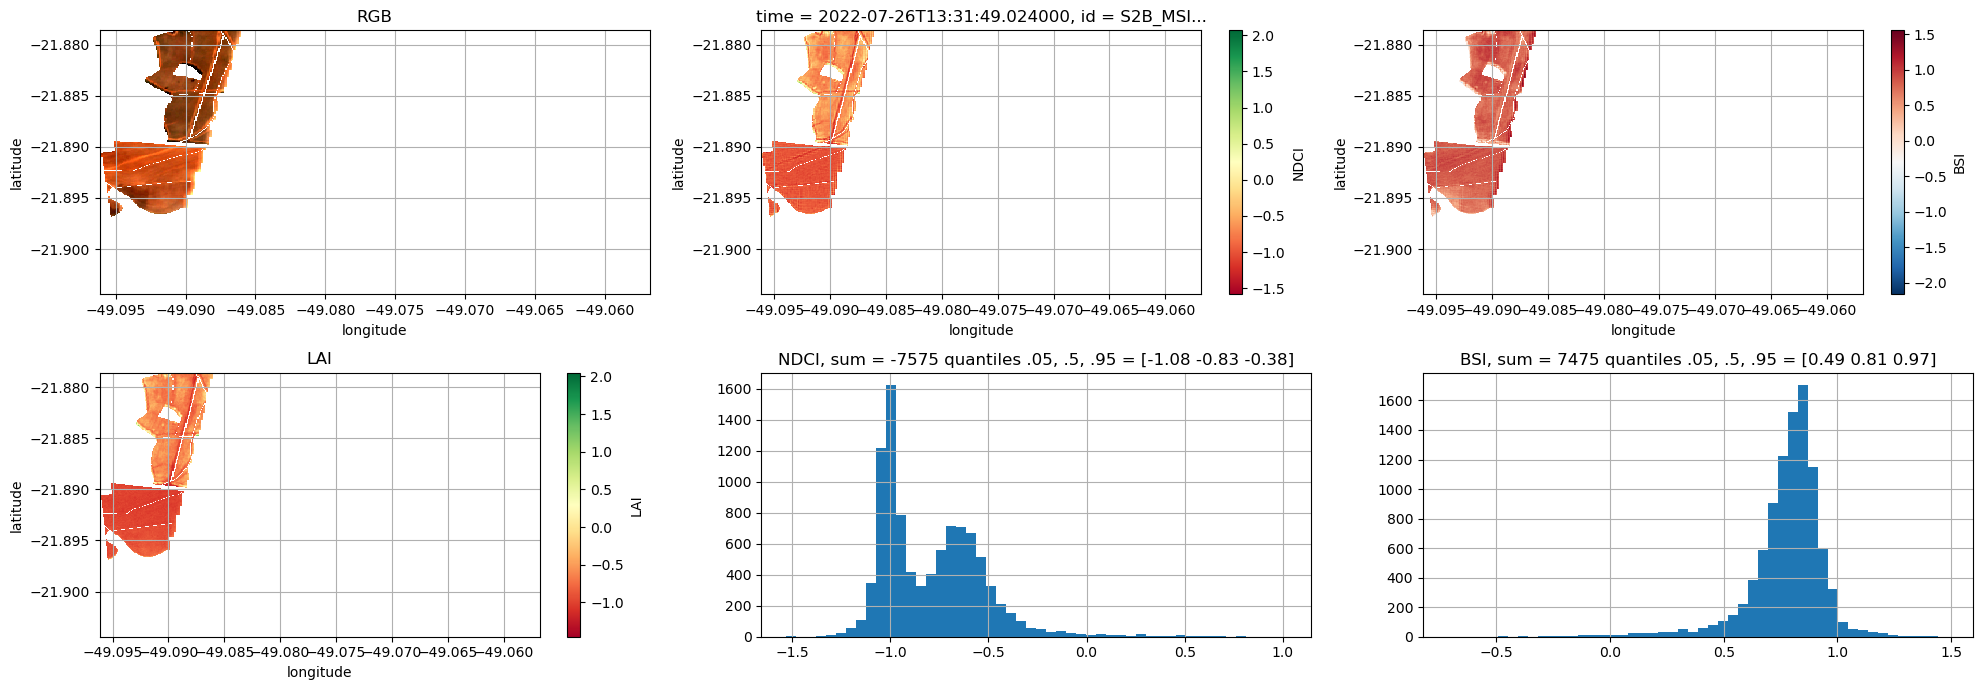

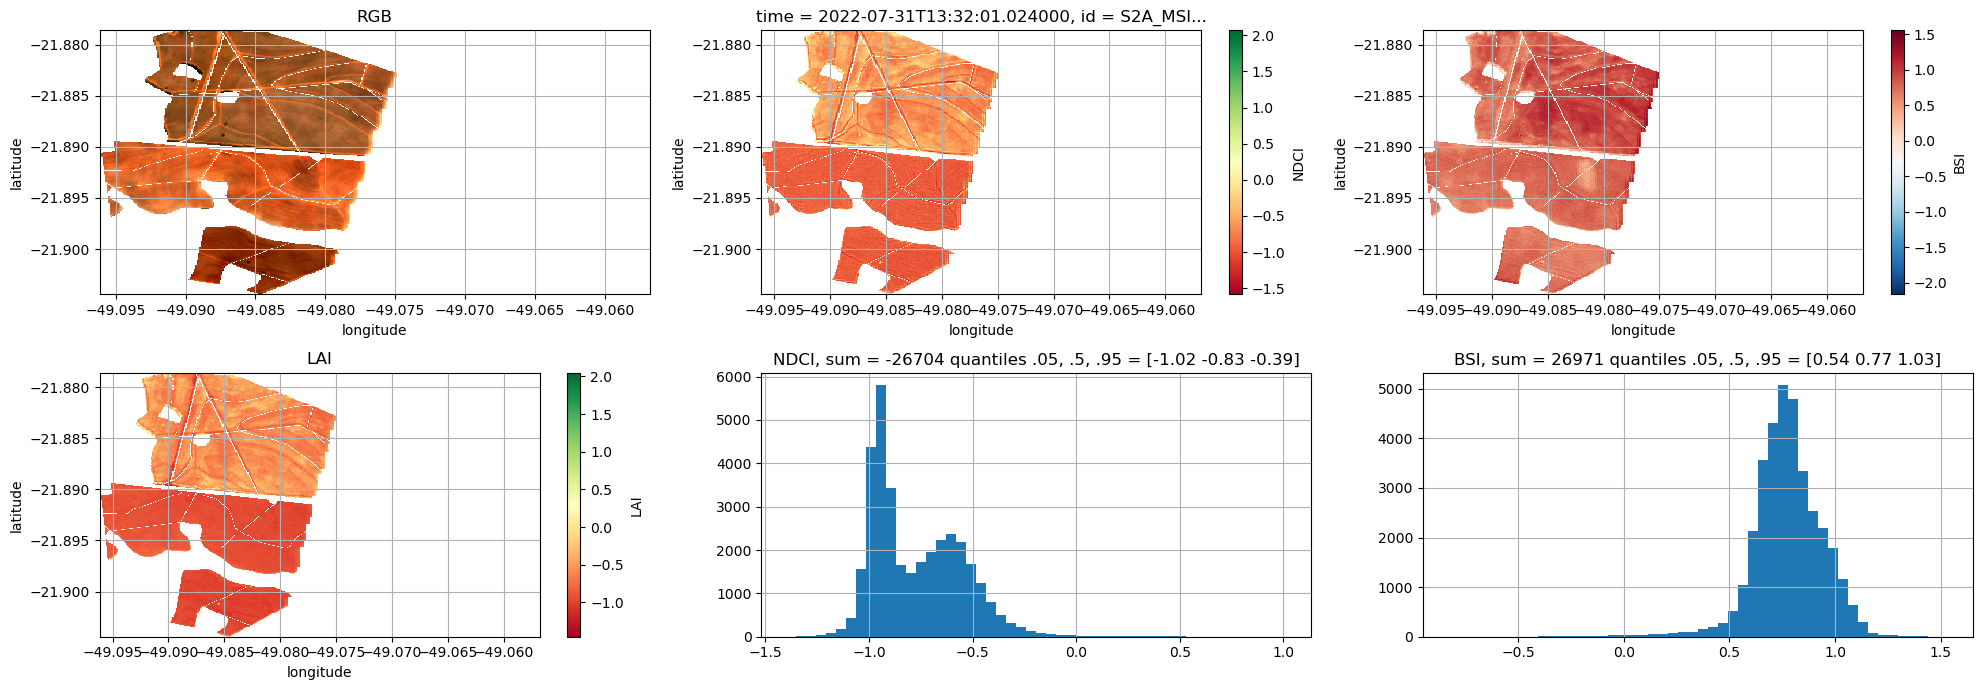

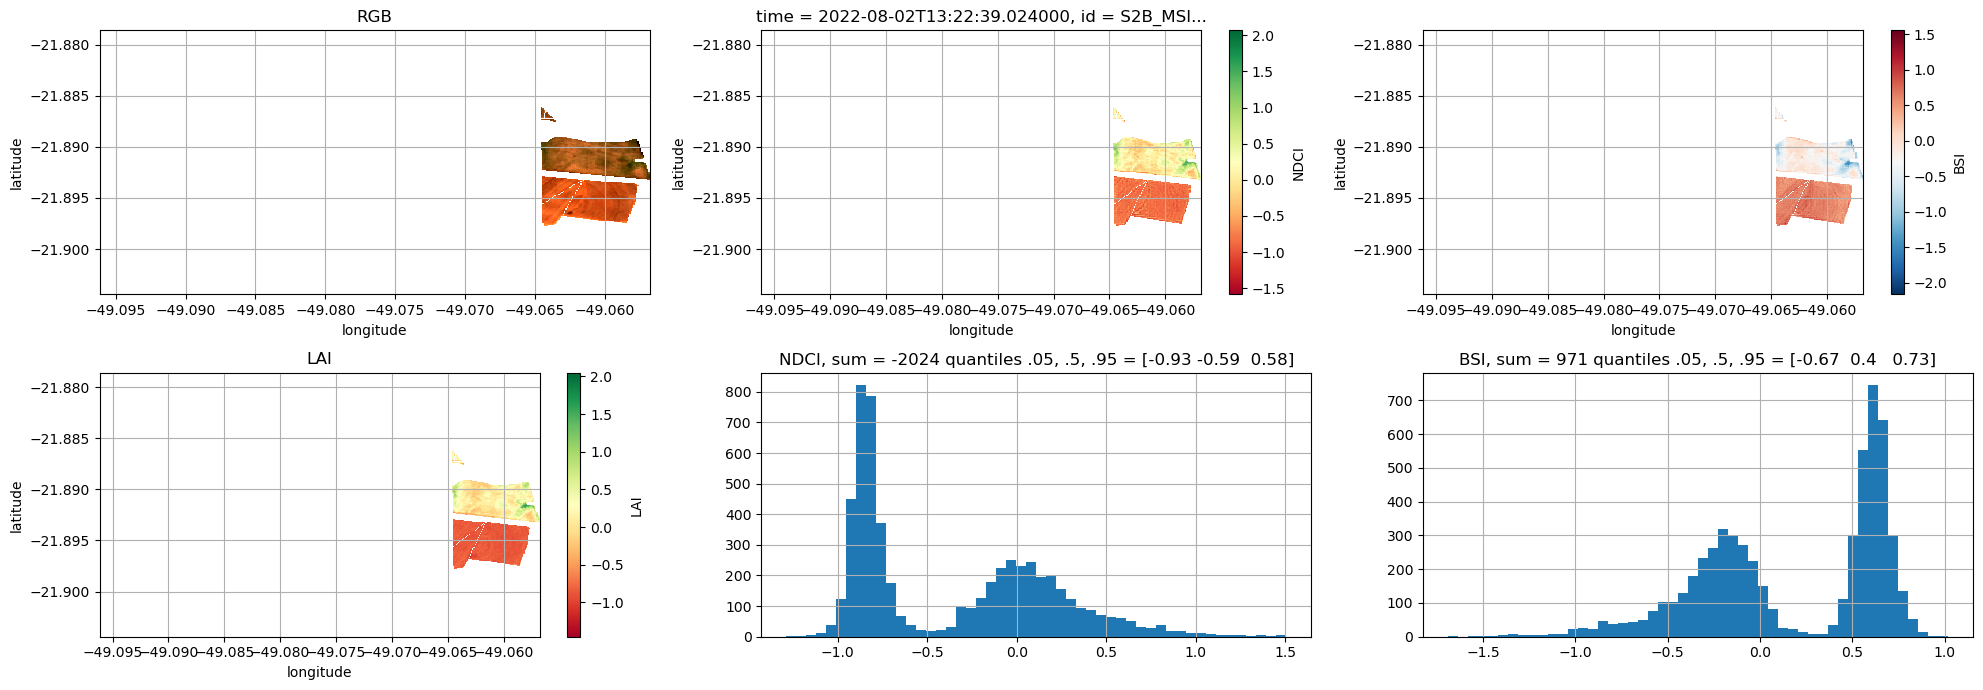

KeyboardInterrupt: 

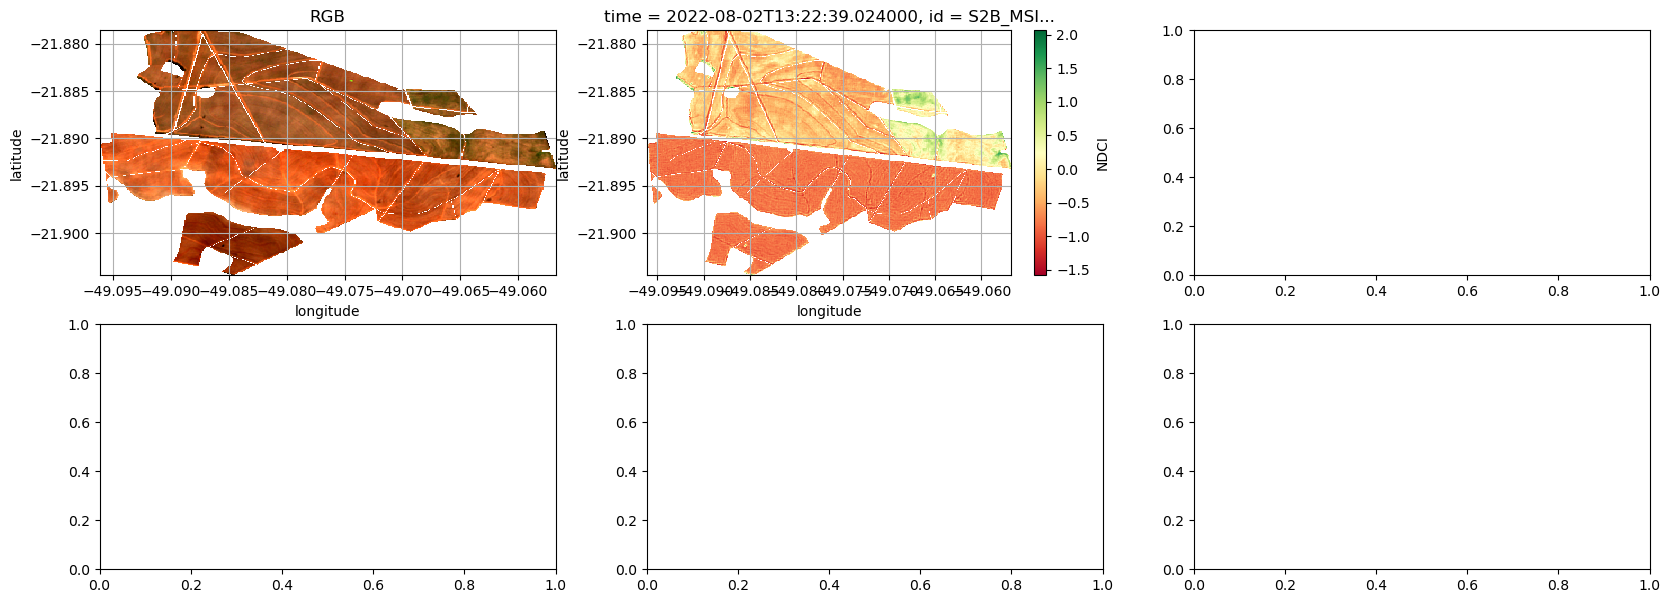

In [21]:
# plot ZSCORES using time slice
timeslice = False

if timeslice:
    zscores_ = zscores.sel(time=slice("2022-06-15", "2023-07-31")).copy(deep=True)
    step = 1
    
if not timeslice:
    zscores_ = zscores.copy()
    step = 1


for t in range(0, len(zscores.time),step):

    fig, ((ax1,ax2,ax3), (ax4,ax5,ax6))  = plt.subplots(2, 3,figsize=(20,7))

    # RGB
    rgb(ds_,index=[t],percentile_stretch=(0.02,0.98), ax=ax1, aspect=1)
    ax1.set_title('RGB')
    ax1.grid()

    # i1 plot
    zscores_[i1].isel(time=[t]).plot(cmap = 'RdYlGn', vmin = mms[i1][0], vmax = mms[i1][1], ax=ax2)
    ax2.grid()

    # i1 histogram
    flat = zscores_[i1].isel(time=[t]).values.flatten()
    flat = np.where((flat > mms[i1][1]) | (flat < mms[i1][0]), np.nan, flat)
    ax5.hist(flat,50)
    ax5.grid()
    ax5.set_title(f'{i1}, sum = {np.nansum(flat):.0f} quantiles .05, .5, .95 = {np.round(np.nanquantile(flat,[.05,.5,.95]),2)}')

    # i2 plot
    # por ser 'BSI', uso a escala invertida
    zscores_[i2].isel(time=[t]).plot(cmap = 'RdBu_r', vmin = mms[i2][0], vmax = mms[i2][1], ax=ax3)
    ax3.set_title(None);
    ax3.grid()

    # i2 histogram
    flat = zscores_[i2].isel(time=[t]).values.flatten()
    flat = np.where((flat > mms[i2][1]) | (flat < mms[i2][0]), np.nan, flat)
    ax6.hist(flat, bins=50)
    ax6.grid()
    ax6.set_title(f'{i2}, sum = {np.nansum(flat):.0f} quantiles .05, .5, .95 = {np.round(np.nanquantile(flat,[.05,.5,.95]),2)}')

    # i3 plot
    zscores_[i3].isel(time=[t]).plot(cmap = 'RdYlGn', vmin = mms[i3][0], vmax = mms[i3][1], ax=ax4)
    ax4.set_title(i3);
    ax4.grid()

    fig.tight_layout();   
    plt.show();plt.close()

### Plotting regular IVs time-series

In [ ]:
step = 50
t = 1

for t in range(0, len(ds_.time),step):
    fig, ((ax1,ax2,ax3), (ax4,ax5,ax6))  = plt.subplots(2, 3,figsize=(20,7))

    rgb(ds_,index=[t],percentile_stretch=(0.02,0.98), ax=ax1, aspect=1)
    ax1.set_title(None)
    ax1.grid()

    ds[i1].isel(time=[t]).plot(cmap = 'RdYlGn', vmin = mms[i1][0], vmax = mms[i1][1], ax=ax2)
    ax2.grid()

    flat = ds[i1].isel(time=[t]).values.flatten()
    flat = np.where((flat> 3.5) | (flat<0), np.nan, flat)
    ax5.hist(flat,50)
    ax5.grid()
    ax5.set_title(f'{i1}, sum = {np.nansum(flat):.0f} quantiles .05, .5, .95 = {np.round(np.nanquantile(flat,[.05,.5,.95]),2)}')

    ds[i2].isel(time=[t]).plot(cmap = 'RdYlGn', vmin = mms[i2][0], vmax = mms[i2][1], ax=ax3)
    ax3.set_title(None);
    ax3.grid()


    flat = ds[i2].isel(time=[t]).values.flatten()
    flat = np.where((flat> 3.5) | (flat<0), np.nan, flat)
    ax6.hist(flat, bins=50)
    ax6.grid()
    ax6.set_title(f'{i2}, sum = {np.nansum(flat):.0f} quantiles .05, .5, .95 = {np.round(np.nanquantile(flat,[.05,.5,.95]),2)}')

    ds[i3].isel(time=[t]).plot(cmap = 'RdYlGn', vmin = mms[i3][0], vmax = mms[i3][1], ax=ax4)
    ax4.set_title(None);
    ax4.grid()

    fig.tight_layout();   
    plt.show();plt.close()